# TwitterMining

Goal: Predict the animal classification of tweets (cat or dog)

## Boilerplate code

In [7]:
#import modules
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import time
from sklearn.feature_extraction import text as sk_fe_text
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, f1_score, recall_score
from TwitterAPI import TwitterAPI
from IPython.display import Image

In [2]:
#Twitter api key
api = TwitterAPI('QNfuwJhdHesrXfpVmYGYx9UYi', '8ZTHg0osCzwOqxvmqwZUNI1KaWu2PI9C4tao29VeEp0UlzlTbH', auth_type = 'oAuth2')

In [3]:
def score(true,pred):
    return (precision_score(true,pred),
            recall_score(true,pred),
            f1_score(true,pred))

In [4]:
def print_score(s):
    print ("""
Precision: {:0.3}
Recall:    {:0.3}
F-SCore:   {:0.3}
""".format(*s))

In [8]:
def searchTwitter(query,feed="search/tweets",api=api,n=100000):
  r = []
  qs = 0
  if len(r)==0:
    r.extend([t for t in api.request("search/tweets",{'q':query,'count':n})])
    qs +=1
  while len(r) < n:
#     print("Querrying twitter for {}. {}/{} gathered.".format(query,len(r),n))
    last = r[-1]['id']
    r.extend([t for t in api.request("search/tweets",{'q':query,'count':n,
                                                        'max_id':last})])
    qs += 1
    if qs > 180:
      time.sleep(840)
      qs = 0
  return r[:n]

In [9]:
#Tweets from Twitter
cats = searchTwitter('#cats')
dogs = searchTwitter('#dogs')

KeyboardInterrupt: 

In [8]:
#converting json from Twitter into a dataframe
cats_d_sub = pd.read_json(json.dumps(cats[:2000]))
dogs_d_sub = pd.read_json(json.dumps(dogs[:2000]))
cats_d = pd.read_json(json.dumps(cats))
dogs_d = pd.read_json(json.dumps(dogs))

#display(cats_d)
#display(dogs_d)

## Naive Bayes

### 2,000 Tweets

In [9]:
#Get text only and replace hashtags with blanks
cats_text = [x.replace("#cats", "") for x in cats_d_sub['text']]
dogs_text = [x.replace("#dogs", "") for x in dogs_d_sub['text']]

In [10]:
#Find the number of times #dogs appear in the cats data
blob = [x.find("#dogs") for x in cats_text]
type(blob)
df1 = pd.DataFrame(blob)
#df1.stack().value_counts()

In [11]:
#Create features and return sparse metrics 
vectorizer = sk_fe_text.CountVectorizer(cats_text+dogs_text)
vectorizer.fit(cats_text+dogs_text)
cats_tdm = vectorizer.transform(cats_text).toarray()
dogs_tdm = vectorizer.transform(dogs_text).toarray()

In [12]:
#Create visible matrices, combine and add the number of times #dogs appear in cats_text to the length of dog_text and subtract
#the same number from the length of cats_text
zeros = np.zeros((len(cats_text) - 185, 1))
ones = np.ones((len(dogs_text) + 185, 1))
catsdogs = np.concatenate((cats_tdm,dogs_tdm),axis=0)
y = np.ravel(np.concatenate((zeros,ones),axis=0))

In [13]:
#Create train/test split for modeling
trainX_sub,testX_sub,trainY_sub,testY_sub = train_test_split(catsdogs,y,test_size=.20)

In [ ]:
#Naive Bayes
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
nb.fit(trainX_sub,trainY_sub)

In [15]:
#Naive Bayes cont'd
print("\n\nNaive Bayes Performance (2,000)")
s = score(testY_sub,nb.predict(testX_sub))
print_score(s)



Naive Bayes Performance (2,000)

Precision: 0.911
Recall:    0.806
F-SCore:   0.855



### 10,000 Tweets

In [16]:
#Get text only and replace hashtags with blanks
cats_text = [x.replace("#cats", "") for x in cats_d['text']]
dogs_text = [x.replace("#dogs", "") for x in dogs_d['text']]

In [17]:
#Find the number of times #dogs appear in the cats data
blob = [x.find("#dogs") for x in cats_text]
type(blob)
df1 = pd.DataFrame(blob)
#df1.stack().value_counts()

In [18]:
#Create features and return sparse metrics 
vectorizer = sk_fe_text.CountVectorizer(cats_text+dogs_text)
vectorizer.fit(cats_text+dogs_text)
cats_tdm = vectorizer.transform(cats_text).toarray()
dogs_tdm = vectorizer.transform(dogs_text).toarray()

In [19]:
#Create visible matrices, combine and add the number of times #dogs appear in cats_text to the length of dog_text and subtract
#the same number from the length of cats_text
zeros = np.zeros((len(cats_text) - 185, 1))
ones = np.ones((len(dogs_text) + 185, 1))
catsdogs = np.concatenate((cats_tdm,dogs_tdm),axis=0)
y = np.ravel(np.concatenate((zeros,ones),axis=0))

In [20]:
#Create train/test split for modeling
trainX,testX,trainY,testY = train_test_split(catsdogs,y,test_size=.20)

In [21]:
#Naive Bayes
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
nb.fit(trainX,trainY)

GaussianNB(priors=None)

In [22]:
#Naive Bayes cont'd
print("\n\nNaive Bayes Performance (10,000)")
s = score(testY,nb.predict(testX))
print_score(s)



Naive Bayes Performance (10,000)

Precision: 0.94
Recall:    0.775
F-SCore:   0.85



## Neural Network

### 2,000 Tweets

In [23]:
#Neural Network
from sklearn.neural_network import MLPClassifier
nn = MLPClassifier()
nn.fit(trainX_sub,trainY_sub)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [24]:
#Neural Network cont'd
print("\n\nNeural Network Performance (2,000)")
s = score(testY_sub,nn.predict(testX_sub))
print_score(s)



Neural Network Performance (2,000)

Precision: 0.894
Recall:    0.856
F-SCore:   0.875



### 10,000 Tweets

In [25]:
#Neural Network
from sklearn.neural_network import MLPClassifier
nn = MLPClassifier()
nn.fit(trainX,trainY)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [26]:
##### Neural Network cont'd
print("\n\nNeural Network Performance (10,000)")
s = score(testY,nn.predict(testX))
print_score(s)



Neural Network Performance (10,000)

Precision: 0.929
Recall:    0.905
F-SCore:   0.917



In [18]:
import matplotlib.pyplot as plt
    
# 2k, 4k, 10k, 100k
x = [2, 4, 10]
precision_nb = [0.911, 0.925, 0.94]
precision_nn = [0.894, 0.888, 0.929]
recall_nb = [0.806, 0.793, 0.775]
recall_nn = [0.856, 0.897, 0.905]
fscore_nb = [0.855, 0.854, 0.85]
fscore_nn = [0.875, 0.893, 0.917]

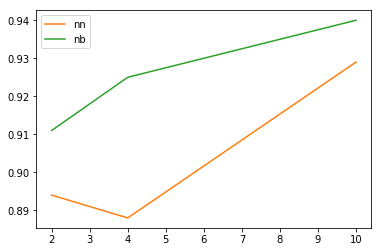

In [21]:
plt.plot(x, precision_nn)
plt.plot(x, precision_nb)
plt.legend(['nn', 'nb'], loc='upper left')
plt.title('precision')
plt.show()


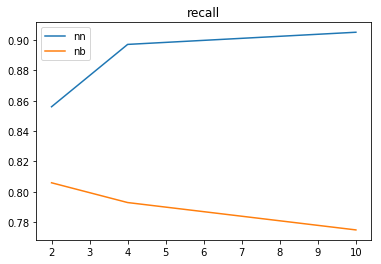

In [22]:
plt.plot(x, recall_nn)
plt.plot(x, recall_nb)
plt.legend(['nn', 'nb'], loc='upper left')
plt.title('recall')
plt.show()

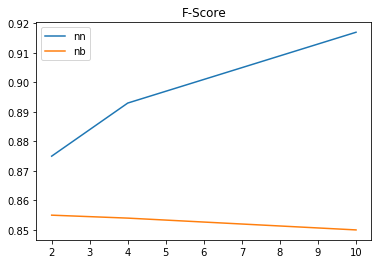

In [23]:
plt.plot(x, fscore_nn)
plt.plot(x, fscore_nb)
plt.legend(['nn', 'nb'], loc='upper left')
plt.title('F-Score')
plt.show()